In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
from IPython import display

from utils import Logger
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torchsummary import summary # Print summary of models, pip install torchsummary
cuda = torch.device('cuda')
torch.cuda.is_available()
from torchvision.utils import save_image

In [3]:
DATA_FOLDER = './data'

In [4]:
def mnist_data():
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True,  transform=transforms.ToTensor(), download=True)


In [5]:
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
# Num batches
num_batches = len(data_loader)
sample_dim = 40
z_dim = 100

In [8]:
class DiscriminatorNet(torch.nn.Module):

    def __init__(self):
        super(DiscriminatorNet, self).__init__()
         
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=32, kernel_size=5, 
                stride=1, padding=2, bias=False
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
       
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=5,
                stride=1, padding=2, bias=False
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Sequential(
            nn.Linear(64*28*28+1000, 1024),
            nn.ReLU(inplace=True)
        )
        self.linear2  = nn.Sequential(
            nn.Linear(10, 1000),
            nn.ReLU(inplace=True)
        )
        self.linear3 = nn.Sequential(
             nn.Linear(1024, 1),            
             nn.Sigmoid()
        )

    def forward(self, x,y):
        # Convolutional layers

        batch_size = x.size(0)
        x = x.view(batch_size, 1, 28,28)
        x = self.conv1(x)

        x = self.conv2(x)

        x = x.view(batch_size, 64*28*28)
        y = self.linear2(y)
        x = torch.cat([x, y], 1)

        x = self.linear1(x)
        x = self.linear3(x)
        
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)
#     return vectors.view(vectors.size(0), 1, 64, 64)

In [9]:
class GeneratorNet(torch.nn.Module):

    def __init__(self,z_dim):
        self.z_dim = z_dim
        super(GeneratorNet, self).__init__()
    
        self.linear1 = nn.Sequential(
            nn.Linear(10, 1000),
            nn.ReLU(inplace=True)
        )
        self.linear2 = nn.Linear(self.z_dim+1000, 64*28*28)
       
        self.batch1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
    
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, 5, 1, 2),
            nn.Sigmoid()
        )
        

    def forward(self, x,y):

        batch_size = x.size(0)
        x = x.reshape(x.size(0),x.size(1))

        y = self.linear1(y)
        x = torch.cat([x, y], 1)

        x = self.linear2(x)
        x = x.view(batch_size, 64, 28, 28)
        x = self.batch1(x)
        x = self.relu1(x)
        # Convolutional layers
        x = self.deconv1(x)
        x = self.deconv2(x)
        return x
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, batch_size, 1, 1))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [10]:
discriminator = DiscriminatorNet()
generator = GeneratorNet(z_dim)
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [11]:
# Optimizers
# d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
# g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.SGD(discriminator.parameters(), lr=0.01)
g_optimizer = optim.SGD(generator.parameters(), lr=0.01)
# d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, .999))
# g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, .999))

# Loss function (Binary Cross Entropy)
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

In [12]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [13]:
def train_discriminator(optimizer, real_data, fake_data,labels):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data,labels)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data,labels)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data,labels):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data,labels)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [14]:
num_test_samples = sample_dim
labels_of_test_samples = Variable(torch.zeros(num_test_samples,10))
Labels = np.repeat([range(10)],sample_dim/10) #generator conditioned 
# Labels = np.repeat(8,num_test_samples) #generator conditioned on 8
for i,index in enumerate(Labels):
    labels_of_test_samples[i][index] = 1
test_noise = noise(num_test_samples)
labels_of_test_samples = labels_of_test_samples.cuda()

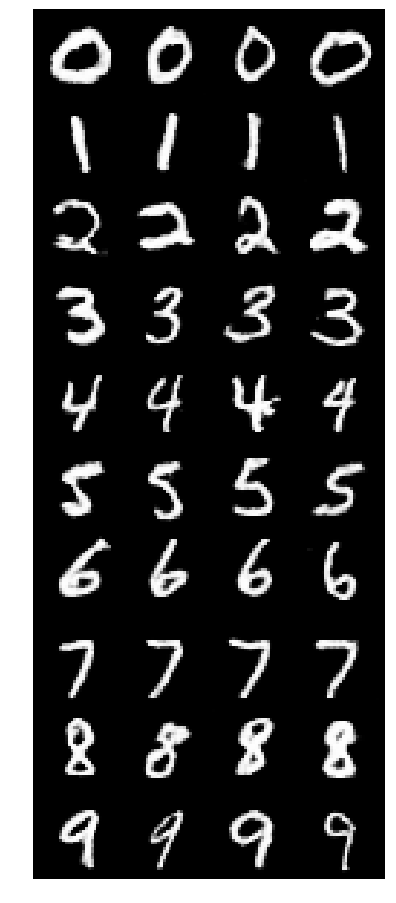

Epoch: [8/200], Batch Num: [400/600]
Discriminator Loss: 1.1577, Generator Loss: 2.8372
D(x): 0.9547, D(G(z)): 0.5757


In [ ]:
%%time
# import time
# samples_dir = './data/images/{}'
logger = Logger(model_name='Vanilla_GAN', data_name='MNIST')
for epoch in range(num_epochs):
    for n_batch, (real_batch,labels) in enumerate(data_loader):
#         print('start,',time.time())
        # 1. Train Discriminator
#         real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): 
            real_data = real_batch.cuda() 
        else: 
            real_data = real_batch

        labels_List = Variable(torch.zeros(real_batch.size(0),10))
        labels_List.scatter_(1, labels.view(batch_size,1), 1)
        labels_List = labels_List.cuda()
#         print('after label,',time.time())

        fake_data = generator(noise(real_data.size(0)),labels_List).detach()
        # Train D
#         print('g,',time.time())

        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data,labels_List)
#         print('train d,',time.time())
        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)),labels_List)
        # Train G
        g_error = train_generator(g_optimizer, fake_data,labels_List)
#         print('train g,',time.time())
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
#         print('after log,',time.time())
        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise,labels_of_test_samples)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
#         logger.save_models(generator, discriminator, epoch)
#         print('after save model,',time.time())
